In [46]:
import pandas as pd
import os
import shutil

In [47]:
def onlyIncludeOneResultPerSplit_old(df):
    filtered_df = pd.DataFrame(columns=df.columns)

    for year in range(2012, 2024):
        #look for spring split
         
        #returns all results from the year
        df_filter = df[df.iloc[:, 1].str.contains(str(year))]

        #returns anything that is in the spring
        search_terms = ['spring']
        df_filter = df_filter[df_filter.iloc[:, 1].apply(lambda x: any(term in x for term in search_terms))]

        if df_filter.shape[0] > 1:
            exclude_terms = ['summer']
            df_filter = df_filter[~df_filter.iloc[:, 1].apply(lambda x: any(term in x for term in exclude_terms))]

        #if there is only 1 result, most likely the team did not make playoffs so their placement is their final placement
        if df_filter.shape[0] == 1:
            df_filter.iloc[0, 1] = str(year) + ' spring'
            filtered_df = pd.concat([filtered_df, df_filter])

        #if there are 2 result, their playoff placement is their final
        elif df_filter.shape[0] == 2:
            search_terms = ['playoffs']
            df_filter = df_filter[df_filter.iloc[:, 1].apply(lambda x: any(term in x for term in search_terms))]
            df_filter.iloc[0, 1] = str(year) + ' spring'
            filtered_df = pd.concat([filtered_df, df_filter])

        elif df_filter.shape[0] >= 3:
            search_terms = ['finals']
            df_filter = df_filter[df_filter.iloc[:, 1].apply(lambda x: any(term in x for term in search_terms))]
            df_filter.iloc[0, 1] = str(year) + ' spring'
            filtered_df = pd.concat([filtered_df, df_filter])


        #look for summer split:
        df_filter = df[df.iloc[:, 1].str.contains(str(year))]

        search_terms = ['summer', 'championship', 'finals']
        df_filter = df_filter[df_filter.iloc[:, 1].apply(lambda x: any(term in x for term in search_terms))]

        if df_filter.shape[0] > 1:
            exclude_terms = ['spring']
            df_filter = df_filter[~df_filter.iloc[:, 1].apply(lambda x: any(term in x for term in exclude_terms))]

        if df_filter.shape[0] == 1:
            df_filter.iloc[0, 1] = str(year) + ' summer'
            filtered_df = pd.concat([filtered_df, df_filter])

        elif df_filter.shape[0] == 2:
            search_terms = ['playoffs', 'finals', 'championship']
            df_filter = df_filter[df_filter.iloc[:, 1].apply(lambda x: any(term in x for term in search_terms))]
            df_filter.iloc[0, 1] = str(year) + ' summer'
            filtered_df = pd.concat([filtered_df, df_filter])
            
        elif df_filter.shape[0] >= 3:
            search_terms = ['finals']
            df_filter = df_filter[df_filter.iloc[:, 1].apply(lambda x: any(term in x for term in search_terms))]
            df_filter.iloc[0, 1] = str(year) + ' summer'
            filtered_df = pd.concat([filtered_df, df_filter])

    return filtered_df.reset_index(drop=True)

In [48]:
def onlyIncludeOneResultPerSplit(df):
    filtered_df = pd.DataFrame(columns=df.columns)

    for year in range(2012, 2024):
        #look for spring split
         
        #returns all results from the year
        df_filter = df[df.iloc[:, 1].str.contains(str(year))]

        #returns anything that is in the spring
        search_terms = ['spring']
        df_filter = df_filter[df_filter.iloc[:, 1].apply(lambda x: any(term in x for term in search_terms))]

        if df_filter.shape[0] >= 1:
            df_filter.iloc[0, 1] = str(year) + ' spring'
            filtered_df = pd.concat([filtered_df, df_filter.iloc[[0]]])


        #look for summer split:
        df_filter = df[df.iloc[:, 1].str.contains(str(year))]

        search_terms = ['summer', 'championship', 'finals']
        df_filter = df_filter[df_filter.iloc[:, 1].apply(lambda x: any(term in x for term in search_terms))]

        if df_filter.shape[0] >= 1:
            df_filter.iloc[0, 1] = str(year) + ' summer'
            filtered_df = pd.concat([filtered_df, df_filter.iloc[[0]]])


    return filtered_df.reset_index(drop=True)

def removeIrrelevantTournaments(df):
    search_terms = ['lcs', 'na', 'lec', 'eu lcs', 'champions', 'korea', 'china', 'lck', 'lpl']
    df = df[df.iloc[:, 1].apply(lambda x: any(term in x.split() for term in search_terms))]

    exclude_terms = ['cl', 'proving', 'expansion', 'academy', 'lock', 'showdown', 'promotion', 'qualifiers', 'qualifier', 'preseason', 'rift', 'worlds', 'iem', 'showmatch']
    df = df[~df.iloc[:, 1].apply(lambda x: any(term in x.split() for term in exclude_terms))]

    return df 


In [49]:
def checksConsecutive(df):
    #filters to see if they have at least 4 consecutive splits
    # Create a copy of df
    df_copy = df.copy()
    
    # Define mapping for seasons
    season_map = {'spring': 0, 'summer': 1}

    # Create a new column in df_copy with encoded year and season
    df_copy['year_season'] = df_copy.iloc[:, 1].apply(lambda x: (int(x.split()[0]) * 2 + season_map[x.split()[1]]))

    # Sort the DataFrame based on the encoded year and season
    df_sorted = df_copy.sort_values(by='year_season')

    # Now check for four consecutive numbers
    df_sorted['diff'] = df_sorted['year_season'].diff()

    # Find where difference is 1 (indicating consecutive year/season) and group these together
    df_sorted['group'] = (df_sorted['diff'] != 1).cumsum()

    # Check if any group has a size of 4 or more
    return any(df_sorted.groupby('group').size() >= 2)


def meetsCriteria(dir, player):
    #filters to see if they have at least 4 consecutive splits
    file_path = dir + '/' + player + '_tournament_results/' + player + '_tournament_results.csv'
    try:
        df = pd.read_csv(file_path, header=None)
    except pd.errors.EmptyDataError:
        df = pd.DataFrame()

    df = df.astype(str).applymap(str.lower)

    if not df.empty:
        df = removeIrrelevantTournaments(df)
    if not df.empty:
        df = onlyIncludeOneResultPerSplit(df)
    if df.empty:
        return df
    else:
        if checksConsecutive(df):
            return df
        else:
            return pd.DataFrame()
        

In [50]:
def extractPhotosdf(folder):
    pictures = os.listdir(folder)
    df = pd.DataFrame(pictures, columns=['File Name'])
    filtered_df = pd.DataFrame(columns=['Year Season', 'File Name'])

    for year in range(2012, 2024):
        # Filter for year
        df_filter = df[df['File Name'].str.contains(str(year))]

        # Filter for spring season
        search_terms = ['spring', 'split_1', 'split 1']
        df_spring = df_filter[df_filter['File Name'].apply(lambda x: any(term in x for term in search_terms))]

        if not df_spring.empty:
            spring_df = pd.DataFrame({'Year Season': [str(year) + ' spring'], 
                                      'File Name': [df_spring.iloc[0, 0]]})
            filtered_df = pd.concat([filtered_df, spring_df], ignore_index=True)
            
        # Filter for summer season
        search_terms = ['summer', 'split 2', 'split_2']
        df_summer = df_filter[df_filter['File Name'].apply(lambda x: any(term in x for term in search_terms))]

        if not df_summer.empty:
            summer_df = pd.DataFrame({'Year Season': [str(year) + ' summer'], 
                                      'File Name': [df_summer.iloc[0, 0]]})
            filtered_df = pd.concat([filtered_df, summer_df], ignore_index=True)
            
    return filtered_df




In [51]:
import pandas as pd
import os

def createDataSet(dir, output_csv_file):
    '''
    Inputs:
    dir - in format 'dataset'
    output_csv_file- in format 'test/data.csv'
    '''
    # Create an initial DataFrame with the desired columns.
    result_df = pd.DataFrame(columns=['Player', 'Season', 'Placement', 'Team'])
    
    for region in os.listdir(dir):
        subDir = os.path.join(dir, region)
        folders = os.listdir(subDir)
        folders = [folder for folder in folders if folder[-7:] != 'results']
        for player in folders:

            file_path = os.path.join(subDir, player + '_tournament_results', player + '_tournament_results.csv')
            
            df = pd.DataFrame()
            try:
                df = pd.read_csv(file_path, header=None)
            except pd.errors.EmptyDataError:
                pass
            
            df = df.astype(str).applymap(str.lower)
            df = removeIrrelevantTournaments(df) if not df.empty else df
            df = onlyIncludeOneResultPerSplit(df) if not df.empty else df
            
            if not df.empty:
                # Create a new DataFrame with 'Player' column and concatenate it with result_df.
                df.columns = ['Placement', 'Season', 'Team']
                df['Player'] = player
                result_df = pd.concat([result_df, df], ignore_index=True)

    # Write the result DataFrame to CSV file.
    result_df.to_csv(output_csv_file, index=False)

#createDataSet('Dataset', 'processedDataset/players.csv')


In [14]:
def copyPhotos(df, photosLocation, outputFolder, playername):
    # Creating the output directory
    if not os.path.exists(outputFolder):
        os.makedirs(outputFolder)

    # Adding a new column to store the new photo names
    df['New File Name'] = ""

    # Iterating over the DataFrame rows
    for index, row in df.iterrows():
        old_photo_name = row['File Name']
        new_photo_name = f"{playername}_{row[0]}.jpg"
        old_photo_path = os.path.join(photosLocation, old_photo_name)
        new_photo_path = os.path.join(outputFolder, new_photo_name)

        # Copying and renaming the photo
        shutil.copyfile(old_photo_path, new_photo_path)
        
        # Saving the new photo name to the DataFrame
        df.loc[index, 'New File Name'] = new_photo_name

    return df


def createPhotos(dir, output_folder):
    for region in os.listdir(dir):
        subDir = os.path.join(dir, region)
        folders = os.listdir(subDir)
        folders = [folder for folder in folders if folder[-7:] != 'results']
        for player in folders:

            photo_file_path = subDir + '/' + player           
            df = extractPhotosdf(photo_file_path)
            output_df = copyPhotos(df, photo_file_path, output_folder, player)
            df.to_csv('processedDataset/photos.csv', mode='a', index=False)

createPhotos('Dataset', 'processedDataset/photos')

In [4]:
import pandas as pd


def reformat_csv(input_file, output_file):
    # Read the input file into a DataFrame.
    df = pd.read_csv(input_file, header=None)

    # Split the first column of the DataFrame into player name and season based on the last two underscores.
    df['Player'], df['Year'], df['Season'] = df.pop(0).str.rsplit('_', 2).str

    # Combine 'Year' and 'Season' back into a single 'Season' column, separated by a space.
    df['Season'] = df['Year'] + ' ' + df['Season']

    # Drop the 'Year' column as it's no longer needed.
    df = df.drop(columns=['Year'])

    # Rename the second column as 'Score'.
    df.rename(columns={1: 'Score'}, inplace=True)
    
    # Reorder the columns
    df = df[['Player', 'Season', 'Score']]

    # Write the DataFrame to the output CSV file.
    df.to_csv(output_file, index=False, header=False)
# Call the function with your input and output file paths.
reformat_csv('processedDataset/06_bmi_FTMP.csv', 'processedDataset/processedBMI.csv')


/tmp/ipykernel_298/511055347.py:9: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df['Player'], df['Year'], df['Season'] = df.pop(0).str.rsplit('_', 2).str


In [7]:
import pandas as pd



# Read in the data, skipping the first row if it's a header
placements = pd.read_csv('processedDataset/players.csv', skiprows=1, names=['Player', 'Season', 'Placement', 'Team'])
bmis = pd.read_csv('processedDataset/processedBMI.csv', skiprows=1, names=['Player', 'Season', 'BMI'])

# Merge the two DataFrames
combined = pd.merge(placements, bmis, on=['Player', 'Season'], how='left')

# Write the merged data back out to a new CSV file
combined.to_csv('processedDataset/combined.csv', index=False)

In [11]:
import pandas as pd
import numpy as np

def calculate_mean(placement):
    if '-' in placement:
        start, end = map(int, placement.split('-'))  # Converts "9 " and " 12" into the integers 9 and 12
        return np.mean([i for i in range(start, end+1)])  # Takes the mean of the integers in the range from 9 to 12 inclusive
    elif placement.isdigit():
        return int(placement)
    else:
        return np.nan  # Returns NaN for non-numeric/non-range values

df = pd.read_csv("processedDataset/combined.csv")
df['Placement'] = df['Placement'].apply(calculate_mean)  # Applies the function to every placement
df = df.dropna(subset=['Placement'])  # Drops rows where placement is NaN (i.e., was not a numeric value or a range)
df.to_csv("processedDataset/combined_2.csv", index=False)

In [73]:
import pandas as pd

# Load the data
df = pd.read_csv("./processedDataset/combined_2.csv")
print(df)

         Player       Season  Placement   Team        BMI
0         sasin  2015 summer       10.0  ⁠⁠ssb        NaN
1         sasin  2016 spring        9.0  ⁠⁠ssb        NaN
2           zet  2016 summer        1.0  ⁠⁠rox  15.569351
3           zet  2017 spring        3.0  ⁠⁠edg  20.566696
4           zet  2017 summer        1.0  ⁠⁠edg        NaN
...         ...          ...        ...    ...        ...
6665      keith  2017 summer        8.0  ⁠⁠fox        NaN
6666      keith  2018 summer        2.0   ⁠⁠c9  33.662567
6667      keith  2019 spring        2.0   ⁠⁠c9  30.069838
6668      keith  2020 spring        6.0   ⁠⁠gg  26.438421
6669  elderpeko  2015 spring        8.0  ⁠⁠wfx        NaN

[6670 rows x 5 columns]


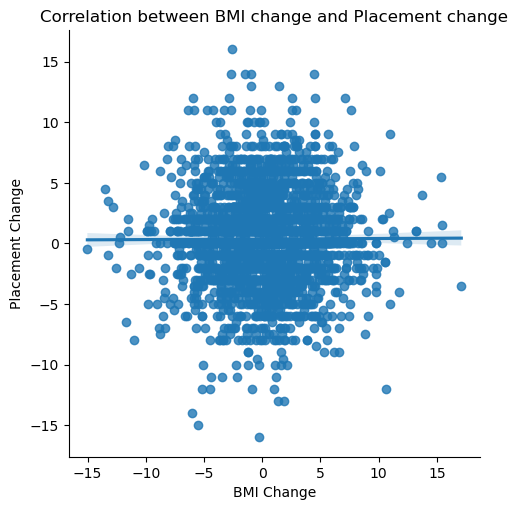

In [12]:
import pandas as pd

# Load the data
df = pd.read_csv("processedDataset/combined_2.csv")

# Ensure we only have players with at least two BMI measurements and corresponding placements
df = df.dropna(subset=['BMI'])
counts = df['Player'].value_counts()
df = df[df['Player'].isin(counts[counts > 1].index)]

# Sort values to ensure we calculate the differences chronologically
df = df.sort_values(['Player', 'Season'])

# Calculate the difference in BMI and placement for each player from one period to the next
df['BMI Change'] = df.groupby('Player')['BMI'].diff()
df['Placement Change'] = df.groupby('Player')['Placement'].diff()

# Drop any rows with missing BMI or placement changes
df = df.dropna(subset=['BMI Change', 'Placement Change'])

df.to_csv("processedDataset/combined_3.csv", index=False)

import matplotlib.pyplot as plt
import seaborn as sns

sns.lmplot(x='BMI Change', y='Placement Change', data=df)
plt.title("Correlation between BMI change and Placement change")
plt.show()

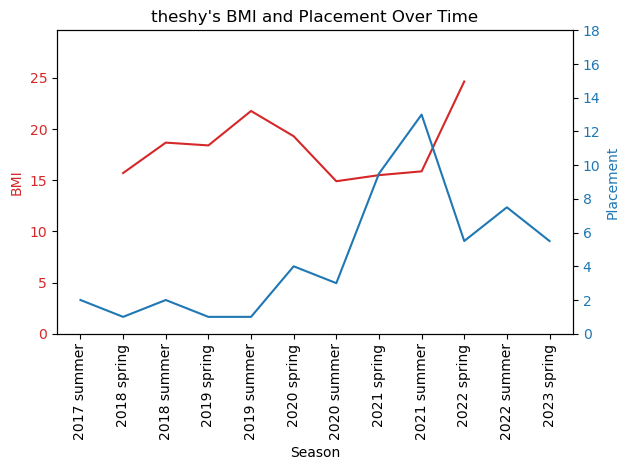

In [74]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_player_bmi_placement(player_name):
    # Load the data
    df = pd.read_csv("./processedDataset/combined_2.csv")

    # Filter the data to include only the selected player
    player_data = df[df['Player'] == player_name]

    # Ensure the data is sorted by season
    player_data = player_data.sort_values('Season')

    # Create a figure and axis
    fig, ax1 = plt.subplots()

    # Plot BMI over time
    color = 'tab:red'
    ax1.set_xlabel('Season')
    ax1.set_ylabel('BMI', color=color)
    ax1.plot(player_data['Season'], player_data['BMI'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Instantiate a second axis that shares the same x-axis
    ax2 = ax1.twinx()

    # We already handled the x-label with ax1
    color = 'tab:blue'
    # Plot placement over time
    ax2.set_ylabel('Placement', color=color)  
    ax2.plot(player_data['Season'], player_data['Placement'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    # Otherwise if the raw data span is small, the plot is unclear because of the scaling of the plot box
    ax2.set_ylim([0, player_data['Placement'].max() + 5])
    ax1.set_ylim([0, player_data['BMI'].max() + 5])

    # Set the x-ticks and rotate them
    ax1.set_xticks(player_data['Season'])
    plt.setp(ax1.get_xticklabels(), rotation=90)

    # Show the plot
    plt.title(f"{player_name}'s BMI and Placement Over Time")
    plt.tight_layout()
    plt.show()

# Now, you can call the function with any player's name, for example:
plot_player_bmi_placement('theshy')


In [28]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

def create_bmi_placement_data(player_df):
    placement_df = player_df.copy() # Copy of player_df for placement regression
    player_df = player_df.dropna(subset=['BMI']) # Drop rows with NaN BMI
    if len(player_df) < 3: # Skip players with less than 3 BMI entries
        return None

    # Convert 'Year Season' to numerical form
    placement_df['Year_Season_Num'] = placement_df['Season'].apply(lambda x: float(x.split()[0]) + (0.0 if 'spring' in x else 0.5))
    player_df['Year_Season_Num'] = player_df['Season'].apply(lambda x: float(x.split()[0]) + (0.0 if 'spring' in x else 0.5))

    # Fit a line to BMI and Placement data
    bmi_slope = np.polyfit(player_df['Year_Season_Num'], player_df['BMI'], 1)[0]
    placement_slope = np.polyfit(placement_df['Year_Season_Num'], placement_df['Placement'], 1)[0]

    # Compute change based on line of best fit
    first_bmi_season = player_df['Year_Season_Num'].min()
    last_bmi_season = player_df['Year_Season_Num'].max()
    first_placement_season = placement_df['Year_Season_Num'].min()
    last_placement_season = placement_df['Year_Season_Num'].max()

    # Changes based on the line of best fit
    bmi_change = (last_bmi_season * bmi_slope) - (first_bmi_season * bmi_slope)
    placement_change = (last_placement_season * placement_slope) - (first_placement_season * placement_slope)

    # Create a summary dataframe for this player
    summary = pd.DataFrame({
        'Player': [player_df['Player'].iloc[0]],
        'BMI_Slope': [bmi_slope],
        'Placement_Slope': [placement_slope],
        'BMI_Change': [bmi_change],
        'Placement_Change': [placement_change]
    })

    return summary

def process_data(df):
    players = df['Player'].unique()
    result_df = pd.DataFrame()
    for player in players:
        player_df = df[df['Player'] == player]
        player_summary = create_bmi_placement_data(player_df)
        if player_summary is not None:
            result_df = pd.concat([result_df, player_summary], ignore_index=True)
    return result_df

df = pd.read_csv('processedDataset/combined_2.csv')
result_df = process_data(df)
result_df.to_csv('processedDataset/combined_5.csv', index=False)


/tmp/ipykernel_298/160850725.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df['Year_Season_Num'] = player_df['Season'].apply(lambda x: float(x.split()[0]) + (0.0 if 'spring' in x else 0.5))
/tmp/ipykernel_298/160850725.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df['Year_Season_Num'] = player_df['Season'].apply(lambda x: float(x.split()[0]) + (0.0 if 'spring' in x else 0.5))
/tmp/ipykernel_298/160850725.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

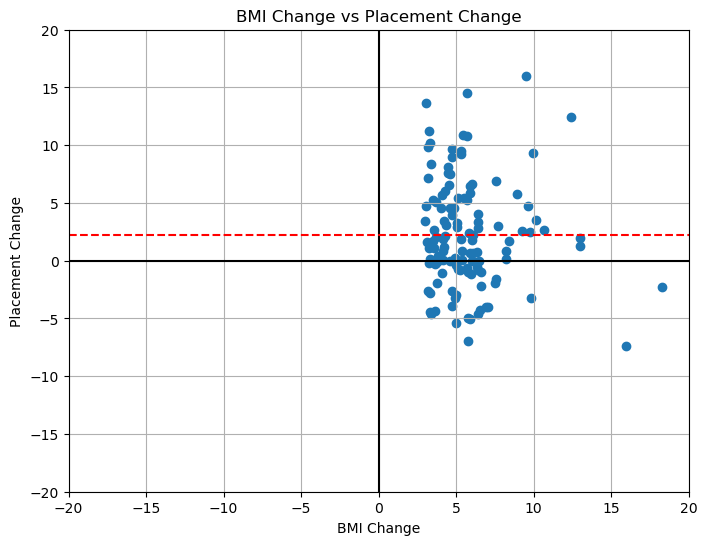

In [77]:
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('processedDataset/combined_5.csv')

# Filter for players with a BMI increase of at least 5
df = df[df['BMI_Change'] >= 3]

# Plot BMI change vs placement change
plt.figure(figsize=(8,6))
plt.scatter(df['BMI_Change'], df['Placement_Change'])
plt.title('BMI Change vs Placement Change')
plt.xlabel('BMI Change')
plt.ylabel('Placement Change')
plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.axhline(0, color='black', linewidth=1.5)  # Horizontal line at 0
plt.axvline(0, color='black', linewidth=1.5)  # Vertical line at 0

average_placement_change = df['Placement_Change'].mean()
plt.axhline(average_placement_change, color='red', linestyle='--')  # Horizontal line at average placement change

plt.grid(True)
plt.show()

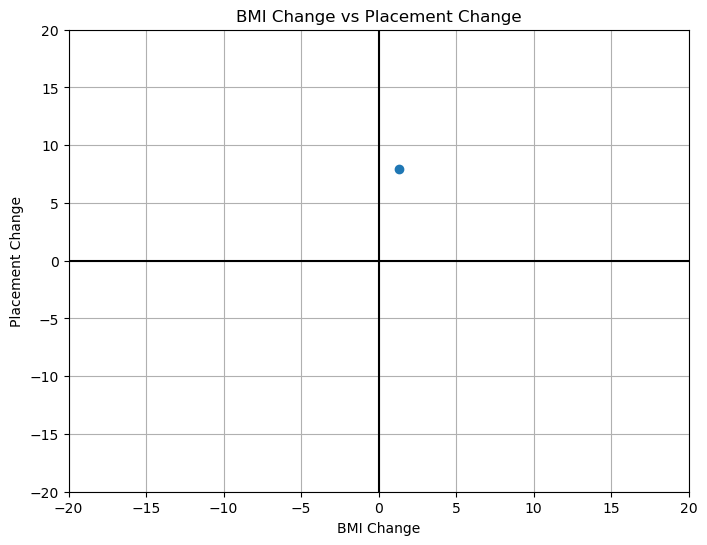

In [75]:
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('processedDataset/combined_5.csv')

# Filter for players with a BMI increase of at least 5
df = df[df['Player'] == 'theshy']

# Plot BMI change vs placement change
plt.figure(figsize=(8,6))
plt.scatter(df['BMI_Change'], df['Placement_Change'])
plt.title('BMI Change vs Placement Change')
plt.xlabel('BMI Change')
plt.ylabel('Placement Change')
plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.axhline(0, color='black', linewidth=1.5)  # Horizontal line at 0
plt.axvline(0, color='black', linewidth=1.5)  # Vertical line at 0
plt.grid(True)
plt.show()

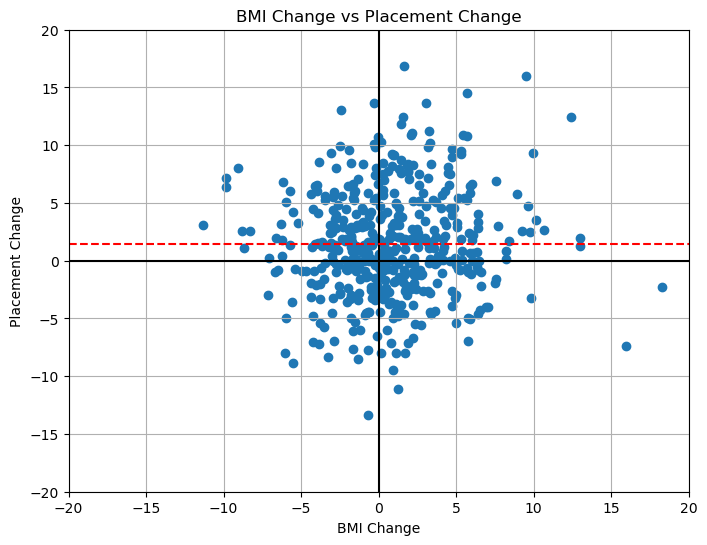

In [78]:
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('processedDataset/combined_5.csv')

# Filter for players with a BMI increase of at least 5

# Plot BMI change vs placement change
plt.figure(figsize=(8,6))
plt.scatter(df['BMI_Change'], df['Placement_Change'])
plt.title('BMI Change vs Placement Change')
plt.xlabel('BMI Change')
plt.ylabel('Placement Change')
plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.axhline(0, color='black', linewidth=1.5)  # Horizontal line at 0
plt.axvline(0, color='black', linewidth=1.5)  # Vertical line at 0
average_placement_change = df['Placement_Change'].mean()
plt.axhline(average_placement_change, color='red', linestyle='--')  # Horizontal line at average placement change

plt.grid(True)
plt.show()

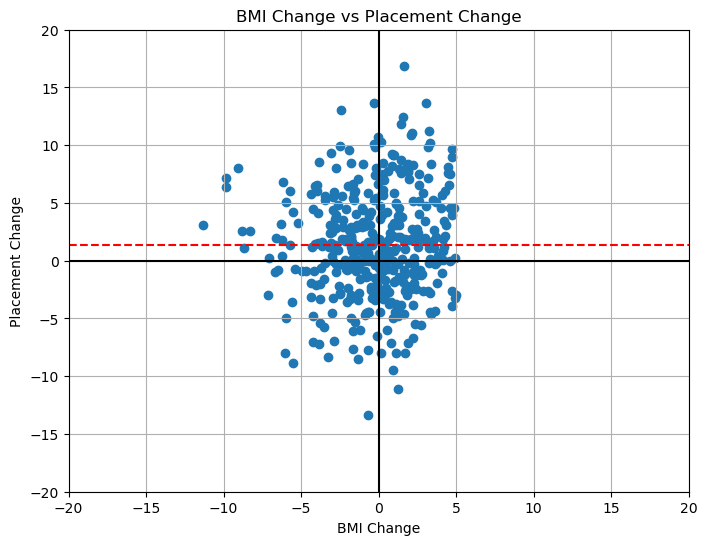

In [79]:
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('processedDataset/combined_5.csv')

# Filter for players with a BMI increase of at least 5
df = df[df['BMI_Change'] <= 5]

# Plot BMI change vs placement change
plt.figure(figsize=(8,6))
plt.scatter(df['BMI_Change'], df['Placement_Change'])
plt.title('BMI Change vs Placement Change')
plt.xlabel('BMI Change')
plt.ylabel('Placement Change')
plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.axhline(0, color='black', linewidth=1.5)  # Horizontal line at 0
plt.axvline(0, color='black', linewidth=1.5)  # Vertical line at 0
average_placement_change = df['Placement_Change'].mean()
plt.axhline(average_placement_change, color='red', linestyle='--')  # Horizontal line at average placement change

plt.grid(True)
plt.show()

In [ ]:
import os
import shutil


def rename_files(directory):
    for filename in os.listdir(directory):
        if ' ' in filename:
            new_name = filename.replace(' ', '_')
            old_file = os.path.join(directory, filename)
            new_file = os.path.join(directory, new_name)
            os.rename(old_file, new_file)
            
# Now call the function providing the directory
# Make sure to replace 'your_directory' with your actual directory.
rename_files('your_directory')


def clean_unpaired_folders(parent_dir):
    # iterate through all first level subfolders in parent directory
    for first_level_subfolder in os.listdir(parent_dir):
        first_level_full_path = os.path.join(parent_dir, first_level_subfolder)
        
        # ensure it's a directory and not a file
        if os.path.isdir(first_level_full_path):
            # iterate through all second level subfolders in the first level subfolder
            for second_level_subfolder in os.listdir(first_level_full_path):
                second_level_full_path = os.path.join(first_level_full_path, second_level_subfolder)
                
                # check if folder doesn't end in "_tournament_results"
                if not second_level_subfolder.endswith("_tournament_results"):
                    
                    # check if corresponding "_tournament_results" folder doesn't exist
                    corresponding_folder = second_level_full_path + "_tournament_results"
                    if not os.path.exists(corresponding_folder):
                        
                        # delete the original folder
                        shutil.rmtree(second_level_full_path)

# Replace 'your_directory' with your actual directory
clean_unpaired_folders('your_directory')

def rename_to_lowercase(dir):
    for root, dirs, files in os.walk(dir, topdown=False):
        # Rename files
        for file in files:
            old_file_path = os.path.join(root, file)
            new_file_path = os.path.join(root, file.lower())
            shutil.move(old_file_path, new_file_path)

        # Rename directories
        for folder in dirs:
            old_folder_path = os.path.join(root, folder)
            new_folder_path = os.path.join(root, folder.lower())
            shutil.move(old_folder_path, new_folder_path)

rename_to_lowercase('Dataset')